In [2]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
import time
from functools import partial
import matplotlib.pyplot as plt
import japanize_matplotlib
from scipy.signal import czt

# JAX設定：倍精度浮動小数点数を有効化
from jax import config
config.update("jax_enable_x64", True)


# --- JAXのカスタムCZT関数 ---
@partial(jax.jit, static_argnames=('m', 'fft_len'))
def custom_czt_jax(x, m, fft_len, w, a=1.0):
    n = x.shape[-1]
    n_range = jnp.arange(n)
    y = x * (a**-n_range) * w**(n_range**2 / 2)
    k_range_full = jnp.arange(-(n - 1), m)
    h = w**(-(k_range_full**2) / 2)
    Y = jnp.fft.fft(y, n=fft_len)
    H = jnp.fft.fft(h, n=fft_len)
    conv_result = jnp.fft.ifft(Y * H)
    k_range_out = jnp.arange(m)
    final_chirp = w**(k_range_out**2 / 2)
    return conv_result[n-1:n-1+m] * final_chirp


# --- パラメータ変換 ---
def convert_physical_to_intuitive_params(phys_params):
    L_phys = phys_params["L"]
    Lambda_c = phys_params["center_period"]
    dz_phys = phys_params["dz"]
    B_scale = phys_params["bandwidth_scale"]
    A_scale = phys_params["amplitude_scale"]
    fs = int(L_phys / dz_phys)
    target_center_k = L_phys / Lambda_c
    target_bandwidth = 2.0 * B_scale
    target_amplitude = 4.0 * A_scale
    return {
        "L": 2 * np.pi, "A": 1, "M": 1000, "fs": fs,
        "target_bandwidth": target_bandwidth,
        "target_amplitude": target_amplitude,
        "target_center_k": target_center_k,
    }


# --- JAXベースのAnsatz生成 ---
def create_lfm_ansatz_jax(params):
    L, fs = params["L"], params["fs"]
    target_center_k, target_bw = params["target_center_k"], params["target_bandwidth"]
    k_start, k_end = target_center_k - target_bw / 2, target_center_k + target_bw / 2
    z = jnp.linspace(-L/2, L/2, fs, endpoint=False)
    inst_phase = k_start * z + (k_end - k_start) / L * (z**2 / 2 + L/2 * z)
    signal = jnp.sign(jnp.cos(inst_phase))
    change_points = jnp.where(jnp.diff(signal) != 0)[0] + 1
    db = jnp.concatenate([jnp.array([0]), change_points, jnp.array([fs])])

    # ベクトル化されたドメイン生成
    starts = db[:-1]
    ends = db[1:]
    valid_mask = starts < ends
    domains = jnp.stack([starts, ends], axis=1)[valid_mask]

    return signal, domains


def create_constant_period_ansatz_jax(params):
    """中心周波数のみを持つ一定周期の信号（Ansatz）と、そのドメインを生成する。"""
    L, fs = params["L"], params["fs"]
    k_center = params["target_center_k"]
    z = jnp.linspace(-L/2, L/2, fs, endpoint=False)

    # 中心波数 k_center を使って一定周期の信号を生成
    signal = jnp.sign(jnp.cos(k_center * z))

    # この信号のドメインも計算しておく
    change_points = jnp.where(jnp.diff(signal) != 0)[0] + 1
    db = jnp.concatenate([jnp.array([0]), change_points, jnp.array([fs])])
    starts = db[:-1]
    ends = db[1:]
    valid_mask = starts < ends
    domains = jnp.stack([starts, ends], axis=1)[valid_mask]

    return signal, domains


# --- JAXベースのコスト関数 ---
def create_cost_function_jax(params):
    L, fs, M = params["L"], params["fs"], params["M"]
    target_center_k, target_bw = params["target_center_k"], params["target_bandwidth"]
    target_amp = params["target_amplitude"]
    k_start = target_center_k - target_bw / 2
    k_end = target_center_k + target_bw / 2
    f_norm_start, f_norm_end = k_start / fs, k_end / fs
    w = jnp.exp(-1j * 2 * jnp.pi * (f_norm_end - f_norm_start) / M)
    a = jnp.exp(1j * 2 * jnp.pi * f_norm_start)
    required_len = fs + M - 1
    fft_len = 1 << (required_len - 1).bit_length()

    @jax.jit
    def cost_function(signal):
        spectrum = custom_czt_jax(
            signal, m=M, fft_len=fft_len, w=w, a=a) * L / fs
        return jnp.sum((jnp.abs(spectrum) - target_amp)**2)
    return cost_function


# --- JAXベースのコスト関数 (対数パワー最大化バージョン) ---
def create_log_cost_function_jax(params):
    L, fs, M = params["L"], params["fs"], params["M"]
    target_center_k, target_bw = params["target_center_k"], params["target_bandwidth"]
    k_start = target_center_k - target_bw / 2
    k_end = target_center_k + target_bw / 2
    f_norm_start, f_norm_end = k_start / fs, k_end / fs
    w = jnp.exp(-1j * 2 * jnp.pi * (f_norm_end - f_norm_start) / M)
    a = jnp.exp(1j * 2 * jnp.pi * f_norm_start)
    required_len = fs + M - 1
    fft_len = 1 << (required_len - 1).bit_length()

    @jax.jit
    def cost_function(signal):
        spectrum = custom_czt_jax(
            signal, m=M, fft_len=fft_len, w=w, a=a) * L / fs
        power_spectrum = jnp.abs(spectrum)**2
        epsilon = 1e-9
        log_power_sum = jnp.sum(jnp.log(power_spectrum + epsilon))
        return -log_power_sum

    return cost_function


# --- JAXベースの焼きなまし ---
@jax.jit
def get_neighbour(key, signal, domains_array):
    signal_len = signal.shape[0]
    n_domains = domains_array.shape[0]
    n_half_domains = n_domains // 2

    # 前半から2つのドメインインデックスをランダムに選ぶ
    key, subkey = random.split(key)
    indices = random.randint(subkey, shape=(
        2,), minval=0, maxval=n_half_domains)

    # 常に start_idx <= end_idx となるようにソート
    start_domain_idx = jnp.min(indices)
    end_domain_idx = jnp.max(indices)

    # 前半部分のマスクを定義
    start_pixel_1 = domains_array[start_domain_idx, 0]
    end_pixel_1 = domains_array[end_domain_idx, 1]

    # 対称な後半部分のマスクを定義
    symmetric_start_idx = n_domains - 1 - end_domain_idx
    symmetric_end_idx = n_domains - 1 - start_domain_idx
    start_pixel_2 = domains_array[symmetric_start_idx, 0]
    end_pixel_2 = domains_array[symmetric_end_idx, 1]

    # マスクを生成
    all_indices = jnp.arange(signal_len)
    mask1 = (all_indices >= start_pixel_1) & (all_indices < end_pixel_1)
    mask2 = (all_indices >= start_pixel_2) & (all_indices < end_pixel_2)
    final_mask = mask1 | mask2

    return jnp.where(final_mask, -signal, signal)


def run_simulated_annealing_jax(key, initial_signal, domains_array, cost_fn, sa_params):
    """
    近傍解をバッチで並列生成・評価するシミュレーテッドアニーリングを実行する。
    """
    n_iter = sa_params["n_iterations"]
    cooling_rate = sa_params["cooling_rate"]
    batch_size = sa_params["batch_size"]  # バッチサイズをパラメータから取得

    vmap_get_neighbour = jax.vmap(get_neighbour, in_axes=(0, None, None))
    vmap_cost_fn = jax.vmap(cost_fn)

    initial_cost = cost_fn(initial_signal)
    cost_history = jnp.zeros(n_iter + 1).at[0].set(initial_cost)

    init_val = (key, initial_signal, initial_cost, initial_signal, initial_cost,
                sa_params["initial_temp"], cost_history)

    def sa_step(i, val):
        key, current_signal, current_cost, best_signal, best_cost, temp, cost_history = val
        key, mutate_key, accept_key = random.split(key, 3)
        batch_keys = random.split(mutate_key, batch_size)

        neighbor_batch = vmap_get_neighbour(
            batch_keys, current_signal, domains_array
        )
        cost_batch = vmap_cost_fn(neighbor_batch)

        best_in_batch_idx = jnp.argmin(cost_batch)
        best_neighbor_signal = neighbor_batch[best_in_batch_idx]
        best_neighbor_cost = cost_batch[best_in_batch_idx]

        acceptance_prob = jnp.exp(-(best_neighbor_cost - current_cost) / temp)
        accept = (best_neighbor_cost < current_cost) | (
            random.uniform(accept_key) < acceptance_prob)

        current_signal = jnp.where(
            accept, best_neighbor_signal, current_signal)
        current_cost = jnp.where(accept, best_neighbor_cost, current_cost)

        is_better = current_cost < best_cost
        best_signal = jnp.where(is_better, current_signal, best_signal)
        best_cost = jnp.where(is_better, current_cost, best_cost)

        new_temp = temp * cooling_rate
        cost_history = cost_history.at[i + 1].set(best_cost)

        return (key, current_signal, current_cost, best_signal, best_cost, new_temp, cost_history)

    print(f"Starting JAX compiled Batch SA (batch_size={batch_size})...")
    start_time = time.time()

    final_val = jax.lax.fori_loop(0, n_iter, sa_step, init_val)

    final_val[-1].block_until_ready()
    end_time = time.time()
    print(f"Finished in {end_time - start_time:.2f} seconds.")

    _, _, _, best_signal, best_cost, _, cost_history = final_val
    print(f"Final cost: {best_cost:.4g}")

    return best_signal, cost_history

In [3]:
physical_parameters = {
    "L": 5e6, "center_period": 7200, "dz": 100,
    "bandwidth_scale": 1.5, "amplitude_scale": 1/2.5
}
sa_params_opt = {
    "batch_size": 1
}
key_opt = random.PRNGKey(int(time.time()))

opt_params = convert_physical_to_intuitive_params(physical_parameters)

# initial_signal, domains = create_lfm_ansatz_jax(opt_params)
initial_signal, domains = create_constant_period_ansatz_jax(opt_params)
# cost_calculator = create_cost_function_jax(opt_params)
cost_calculator = create_log_cost_function_jax(opt_params)

print("Warming up JIT compilation...")
_ = cost_calculator(initial_signal).block_until_ready()
key = random.PRNGKey(int(time.time()))
_ = get_neighbour(key, initial_signal, domains).block_until_ready()
print("JIT warmup finished.")

Warming up JIT compilation...
JIT warmup finished.


In [61]:
from bayes_opt import BayesianOptimization

# --- ベイズ最適化 ---

# 最適化プロセス全体で最良の結果を保持するための変数
best_overall_cost = float('inf')
best_overall_signal = None
best_overall_history = None


# 1. 目的関数の定義
def objective(initial_temp, cooling_rate):
    """
    与えられたハイパーパラメータでSAを実行し、コストの負の値を返す。
    （bayesian-optimizationは最大化を目指すため）
    最良の結果が見つかった場合は、グローバル変数を更新する。
    """
    global best_overall_cost, best_overall_signal, best_overall_history, sa_params_opt, key_opt

    # SAのパラメータを設定
    # 注意：探索中は計算時間を短縮するため、イテレーション回数を減らしています。
    sa_params_opt["initial_temp"] = initial_temp
    sa_params_opt["cooling_rate"] = cooling_rate
    sa_params_opt["n_iterations"] = 10000

    # 毎回異なる乱数シードで実行
    key_opt = random.PRNGKey(int(time.time()))

    # SAを実行
    optimized_signal_opt, cost_history_opt = run_simulated_annealing_jax(
        key_opt, initial_signal, domains, cost_calculator, sa_params_opt
    )

    # 最終コストを取得
    final_cost = float(cost_history_opt[-1])
    print(
        f"Params: temp={initial_temp:.2f}, rate={cooling_rate:.5f} -> Final Cost: {final_cost:.4f}")

    # これまでの最良コストより良い結果であれば、信号と履歴を保存
    if final_cost < best_overall_cost:
        print(f"*** New best cost found: {final_cost:.4f} ***")
        best_overall_cost = final_cost
        best_overall_signal = optimized_signal_opt
        best_overall_history = cost_history_opt

    # ライブラリは最大化を目指すため、コストの負の値を返す
    return -final_cost


# 2. 探索空間の定義
pbounds = {
    'initial_temp': (1e-1, 1e2),
    'cooling_rate': (0.999, 0.99999),
}

# 3. ベイズ最適化の実行
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=1,  # 再現性のため
)

# init_points: 最初にランダムに試行する回数
# n_iter: ベイズ最適化（探索と活用）を行う回数
print("Starting Bayesian optimization for SA parameters...")
optimizer.maximize(
    init_points=5,
    n_iter=30,
)
print("Bayesian optimization finished.")

# 最適化結果の表示
print(f"\nBest score during optimization: "
      f"{-optimizer.max['target']:.4f}")  # type: ignore
print(f"Best parameters found: {optimizer.max['params']}")  # type: ignore

# 4. 最適化中に見つかった最良の信号と履歴を使用
optimized_signal = best_overall_signal
cost_history = best_overall_history

print("\nUsing the best signal and history found during the optimization process.")

# jnp.save("optimized_const_signal_7.npy", optimized_signal)  # type: ignore
# jnp.save("const_cost_history_7.npy", cost_history)  # type: ignore

Starting Bayesian optimization for SA parameters...
|   iter    |  target   | coolin... | initia... |
-------------------------------------------------
Starting JAX compiled Batch SA (batch_size=1)...
Finished in 4.28 seconds.
Final cost: -836.9
Params: temp=72.06, rate=0.99941 -> Final Cost: -836.9430
*** New best cost found: -836.9430 ***
| 1         | 836.9     | 0.9994    | 72.06     |
Starting JAX compiled Batch SA (batch_size=1)...
Finished in 4.17 seconds.
Final cost: -850.1
Params: temp=30.30, rate=0.99900 -> Final Cost: -850.1332
*** New best cost found: -850.1332 ***
| 2         | 850.1     | 0.999     | 30.3      |
Starting JAX compiled Batch SA (batch_size=1)...
Finished in 4.19 seconds.
Final cost: -1030
Params: temp=9.32, rate=0.99915 -> Final Cost: -1029.6657
*** New best cost found: -1029.6657 ***
| 3         | 1.03e+03  | 0.9991    | 9.325     |
Starting JAX compiled Batch SA (batch_size=1)...
Finished in 4.43 seconds.
Final cost: -377.1
Params: temp=34.62, rate=0.9991

In [ ]:
sa_params_opt = {
    "initial_temp": 5,
    "cooling_rate": 0.999,
    "n_iterations": 10000,
    "batch_size": 1
}

# 毎回異なる乱数シードで実行
key_opt = random.PRNGKey(int(time.time()))

# SAを実行
optimized_signal, cost_history = run_simulated_annealing_jax(
    key_opt, initial_signal, domains, cost_calculator, sa_params_opt
)

Starting JAX compiled Batch SA (batch_size=1)...
Finished in 4.37 seconds.
Final cost: -1197


In [4]:
# 保存してた結果を見たい場合 (or 再開したい場合)
optimized_signal = jnp.load("optimized_const_signal_8.npy")
cost_history = jnp.load("const_cost_history_8.npy")

In [65]:
# 続きの最適化 (このブロックを何度も実行すると何回でも追加の探索ができる)
current_cost = cost_calculator(optimized_signal)
print(f"Current cost before further optimization: {current_cost:.4g}")

sa_params_opt["n_iterations"] = 10000
sa_params_opt["initial_temp"] = 1
sa_params_opt["cooling_rate"] = 0.999
sa_params_opt["batch_size"] = 4

initial_signal = optimized_signal

optimized_signal, cost_history = run_simulated_annealing_jax(
    key_opt, initial_signal, domains, cost_calculator, sa_params_opt
)

Current cost before further optimization: -1097
Starting JAX compiled Batch SA (batch_size=4)...
Finished in 5.67 seconds.
Final cost: -1097


In [ ]:
# 保存する場合これ、保存したら必ずコメントアウトする
# jnp.save("optimized_const_signal_8.npy", optimized_signal)
# jnp.save("const_cost_history_8.npy", cost_history)

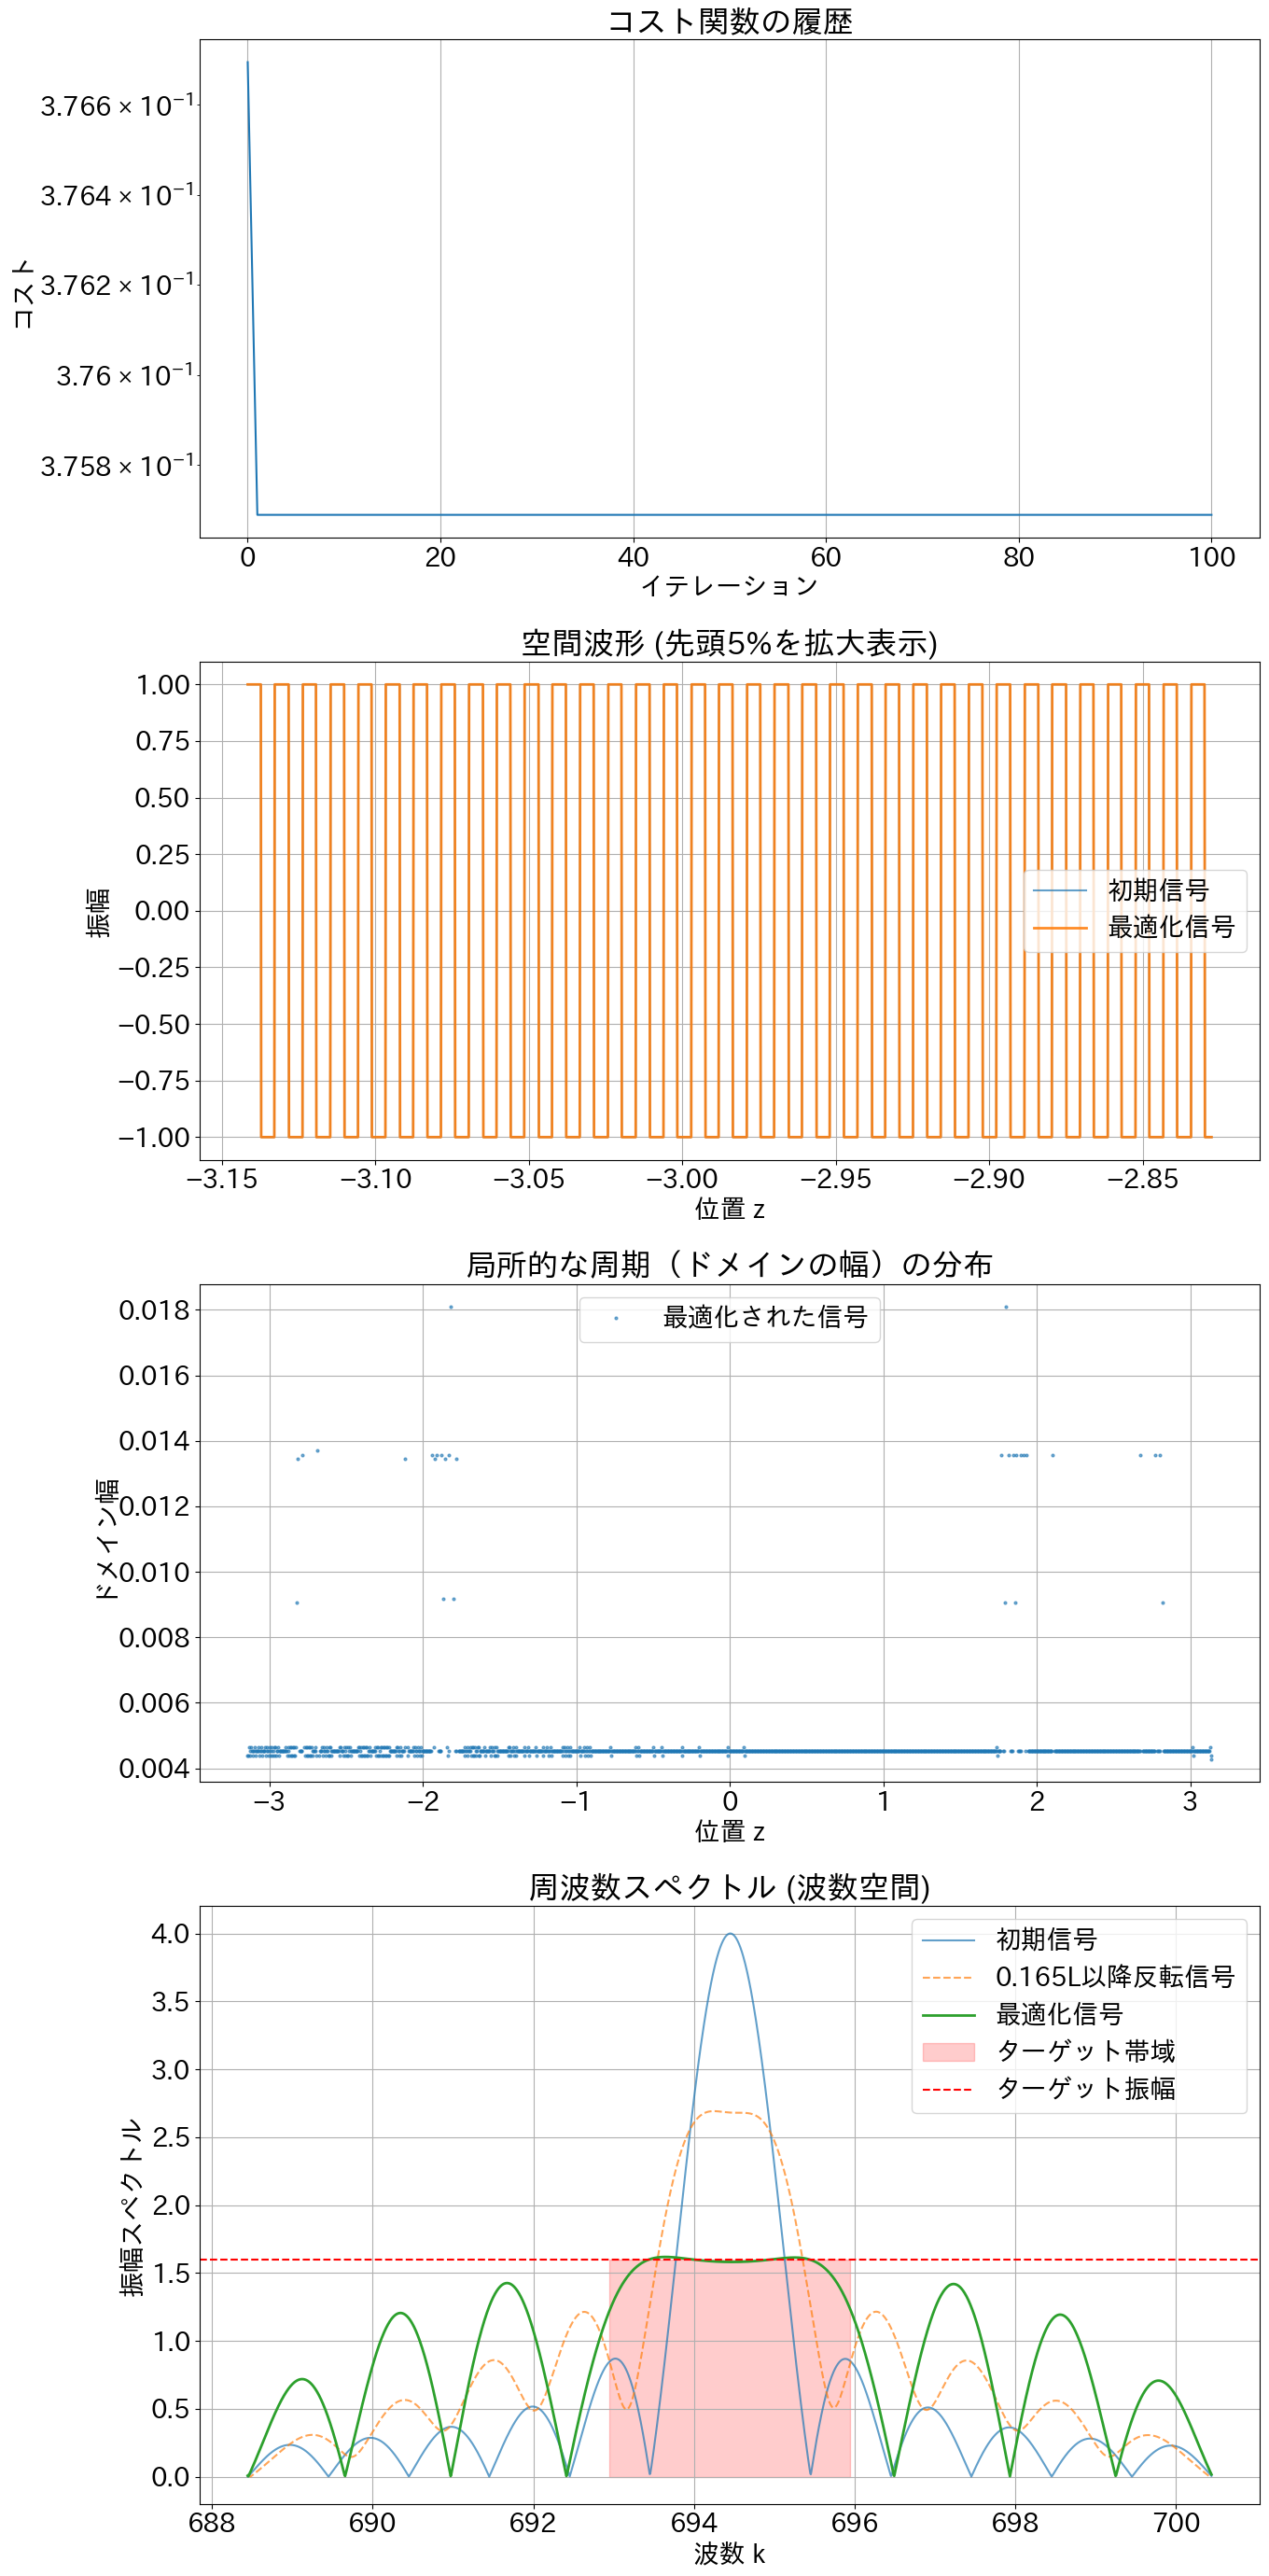

In [5]:
# --- 結果のプロット（改良版）---
def get_domains_from_signal(signal):
    """信号からドメイン（+1/-1が連続する区間）を計算するヘルパー関数"""
    fs = signal.shape[0]
    # 信号の変化点を検出
    change_points = jnp.where(jnp.diff(signal) != 0)[0] + 1
    # 区間の境界を配列にまとめる
    db = jnp.concatenate([jnp.array([0]), change_points, jnp.array([fs])])

    starts = db[:-1]
    ends = db[1:]
    # 有効なドメイン（開始 < 終了）のみを抽出
    valid_mask = starts < ends
    domains = jnp.stack([starts, ends], axis=1)[valid_mask]
    return np.array(domains)


def plot_final_results_with_zoom(initial_sig, optimized_sig, flipped_sig, params, cost_history):
    """
    ズーム表示と局所周期プロット、さらに追加の比較信号をプロットする関数
    """
    initial_sig_np = np.array(initial_sig)
    optimized_sig_np = np.array(optimized_sig)
    flipped_sig_np = np.array(flipped_sig)  # 0.165Lで反転させた信号
    cost_history_np = np.array(cost_history)

    # 4行1列のプロットを作成
    _, axes = plt.subplots(4, 1, figsize=(14, 28), gridspec_kw={
        'height_ratios': [1, 1, 1, 1.2]})

    L, fs, M = params["L"], params["fs"], params["M"]
    target_center_k, target_bw, target_amp = params["target_center_k"], params[
        "target_bandwidth"], params["target_amplitude"]
    z = np.linspace(-L/2, L/2, fs, endpoint=False)

    # 1. コスト関数の履歴
    axes[0].plot(np.abs(cost_history_np))
    axes[0].set_title('コスト関数の履歴')
    axes[0].set_xlabel('イテレーション')
    axes[0].set_ylabel('コスト')
    axes[0].set_yscale('log')
    axes[0].grid(True)

    # 2. 空間波形 (先頭5%をズーム)
    zoom_range = int(fs * 0.05)
    axes[1].plot(z[:zoom_range], initial_sig_np[:zoom_range],
                 label='初期信号', alpha=0.7)
    axes[1].plot(z[:zoom_range], optimized_sig_np[:zoom_range],
                 label='最適化信号', alpha=0.9, linewidth=2)
    axes[1].set_title('空間波形 (先頭5%を拡大表示)')
    axes[1].set_xlabel('位置 z')
    axes[1].set_ylabel('振幅')
    axes[1].legend()
    axes[1].grid(True)

    # 3. 局所周期（ドメイン幅）のプロット
    # 各信号のドメイン情報を計算
    initial_domains = get_domains_from_signal(initial_sig_np)
    optimized_domains = get_domains_from_signal(optimized_sig_np)

    # ドメインの中心位置と幅を計算
    initial_domain_pos = z[initial_domains[:, 0]]
    initial_domain_width = (
        initial_domains[:, 1] - initial_domains[:, 0]) * (L/fs)

    optimized_domain_pos = z[optimized_domains[:, 0]]
    optimized_domain_width = (
        optimized_domains[:, 1] - optimized_domains[:, 0]) * (L/fs)

    axes[2].plot(optimized_domain_pos, optimized_domain_width,
                 'o', markersize=2, alpha=0.6, label='最適化された信号')
    # axes[2].plot(initial_domain_pos, initial_domain_width,
    #              'o', markersize=2, alpha=0.6, label='初期信号')
    axes[2].set_title('局所的な周期（ドメインの幅）の分布')
    axes[2].set_xlabel('位置 z')
    axes[2].set_ylabel('ドメイン幅')
    axes[2].legend()
    axes[2].grid(True)

    # 4. 周波数スペクトル
    k_view_width = target_bw * 2
    k_start_view, k_end_view = target_center_k - \
        k_view_width, target_center_k + k_view_width
    f_norm_start_view, f_norm_end_view = k_start_view / fs, k_end_view / fs
    view_czt_params = {'m': M*2, 'w': np.exp(-1j*2*np.pi*(
        f_norm_end_view-f_norm_start_view)/(M*2)), 'a': np.exp(1j*2*np.pi*f_norm_start_view)}
    k_axis_view = np.linspace(k_start_view, k_end_view, M*2)

    initial_spec = np.abs(czt(initial_sig_np, **view_czt_params) * L / fs)
    optimized_spec = np.abs(
        czt(optimized_sig_np, **view_czt_params) * L / fs)
    # ---- ご要望によるプロットの置き換え ----
    flipped_spec = np.abs(czt(flipped_sig_np, **view_czt_params) * L / fs)

    axes[3].plot(k_axis_view, initial_spec, label='初期信号', alpha=0.7)
    # ---- ご要望によるプロットの置き換え ----
    axes[3].plot(k_axis_view, flipped_spec,
                 label='0.165L以降反転信号', alpha=0.7, linestyle='--')
    axes[3].plot(k_axis_view, optimized_spec, label='最適化信号', linewidth=2)

    k_min_target, k_max_target = target_center_k - \
        target_bw / 2, target_center_k + target_bw / 2
    axes[3].fill_between([k_min_target, k_max_target], 0,
                         target_amp, color='red', alpha=0.2, label='ターゲット帯域')
    axes[3].axhline(y=target_amp, color='r', linestyle='--', label='ターゲット振幅')
    axes[3].set_title('周波数スペクトル (波数空間)')
    axes[3].set_xlabel('波数 k')
    axes[3].set_ylabel('振幅スペクトル')
    axes[3].legend()
    axes[3].grid(True)

    plt.tight_layout()
    plt.show()


plt.rcParams.update({'font.size': 20})

flip_index = int(len(initial_signal) * 0.165)
flipped_signal = np.array(initial_signal)
flipped_signal[flip_index:] *= -1

plot_final_results_with_zoom(initial_signal, optimized_signal,
                             flipped_signal, opt_params, cost_history)